In [1]:
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import Sigmoid
from torch.nn import LogSoftmax
from torch import flatten
import torch.optim as optim
from torch import nn
from sklearn.metrics import classification_report

DIRECTORY = 'data'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
def load_data():
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
    names = [n.decode('utf-8')
             for n in unpickle(DIRECTORY + "/batches.meta")[b'label_names']]
    x_train = None
    y_train = []

    for i in range(1, 3):
        data = unpickle(DIRECTORY + "/data_batch_" + str(i))
        if i > 1:
            x_train = np.append(x_train, data[b'data'], axis=0)
        else:
            x_train = data[b'data']
        y_train += data[b'labels']

    data = unpickle(DIRECTORY + "/test_batch")

    x_test = data[b'data']
    y_test = data[b'labels']

    return names, x_train, y_train, x_test, y_test


In [3]:
def plot_tensor(tensor, perm=None):
    if perm == None:
        perm = (1, 2, 0)
    plt.figure()
    plt.imshow(tensor.permute(perm).cpu().numpy().astype(np.uint8))
    plt.show()


In [4]:
names, x_train, y_train, x_test, y_test = load_data()
names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
x_train_tensors = torch.tensor(x_train).to(device)
y_train_tensors = torch.tensor(y_train).to(device)
x_train_tensors = torch.reshape(x_train_tensors, [20000, 3, 32, 32])
x_test_tensors = torch.tensor(x_train).to(device)
y_test_tensors = torch.tensor(y_train).to(device)
x_test_tensors = torch.reshape(x_test_tensors, [20000, 3, 32, 32])

x_test_tensors.shape


torch.Size([20000, 3, 32, 32])

In [6]:
def get_max(output):
  return torch.argmax(output, dim=1)

class Net(Module):
  def __init__(self, num_channels, classes) -> None:
    super(Net, self).__init__()
    
    self.losses = []

    # first set | conv_layer -> relu -> pool
    self.conv1 = Conv2d(in_channels=num_channels, out_channels=6, kernel_size=(5, 5), padding='same')
    self.sig1 = Sigmoid()
    self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # second set | conv -> relu -> pool
    self.conv2 = Conv2d(in_channels=6, out_channels=9, kernel_size=(3, 3), padding='same')
    self.sig2 = Sigmoid()
    self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

    # initializa fully connected layer
    self.fc1 = Linear(in_features=576, out_features=1000)
    self.sig3 = Sigmoid()

    # initialize softmax classifier
    self.fc2 = Linear(in_features=1000, out_features=classes)
    self.log_soft_max = LogSoftmax(dim=1)

  def forward(self, x):
    # the x data passes through our first set 
    # conv -> relu -> pool layers
    x = self.conv1(x)
    x = self.sig1(x)
    x = self.maxpool1(x)

    # passes the output from previous layer to through the second

    x = self.conv2(x)
    x = self.sig2(x)
    x = self.maxpool2(x)

    # flatten the output and passes it
    x = flatten(x, 1)
    x = self.fc1(x)
    x = self.sig3(x)

    # pass the output to our softmax to get our final output
    x = self.fc2(x)
    return self.log_soft_max(x)

In [7]:
net = Net(num_channels=3, classes=10)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-2, momentum=1e-9)

In [8]:

loss_val = 0.0

for e in range(5000):
  net.train()

  pred = net(x_train_tensors.float())

  # total_train_loss = 0
  # total_val_loss = 0

  # train_correct = 0
  # val_correct = 0

  loss = criterion(pred, y_train_tensors)
  net.losses.append(loss.item())
  loss.backward()
  optimizer.step()


In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


y_true = y_train_tensors.cpu().detach().numpy()
y_pred = get_max(pred).cpu().detach().numpy()

cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix

array([[1660,   12,   44,   34,   72,   20,    8,   41,   66,   32],
       [  35, 1658,   15,   25,   15,   15,   14,   34,   53,  117],
       [  53,   11, 1532,  118,   97,   53,   72,   72,   22,   12],
       [  17,    3,   62, 1527,   76,  135,   79,   80,   14,   18],
       [  12,    6,   58,   66, 1608,   47,   85,  105,   11,   11],
       [  16,    7,   63,  277,   63, 1286,   75,  107,   20,   11],
       [   9,    5,   32,   94,   90,   42, 1697,   50,    4,   15],
       [  23,   13,   23,   67,   88,   34,   22, 1728,   13,   16],
       [  95,   35,   14,   25,   31,   15,    6,   24, 1722,   45],
       [  34,   86,   12,   52,   22,   14,   26,   50,   27, 1643]],
      dtype=int64)

In [10]:
print(classification_report(y_true, y_pred, target_names=names))

              precision    recall  f1-score   support

    airplane       0.85      0.83      0.84      1989
  automobile       0.90      0.84      0.87      1981
        bird       0.83      0.75      0.79      2042
         cat       0.67      0.76      0.71      2011
        deer       0.74      0.80      0.77      2009
         dog       0.77      0.67      0.72      1925
        frog       0.81      0.83      0.82      2038
       horse       0.75      0.85      0.80      2027
        ship       0.88      0.86      0.87      2012
       truck       0.86      0.84      0.85      1966

    accuracy                           0.80     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.81      0.80      0.80     20000



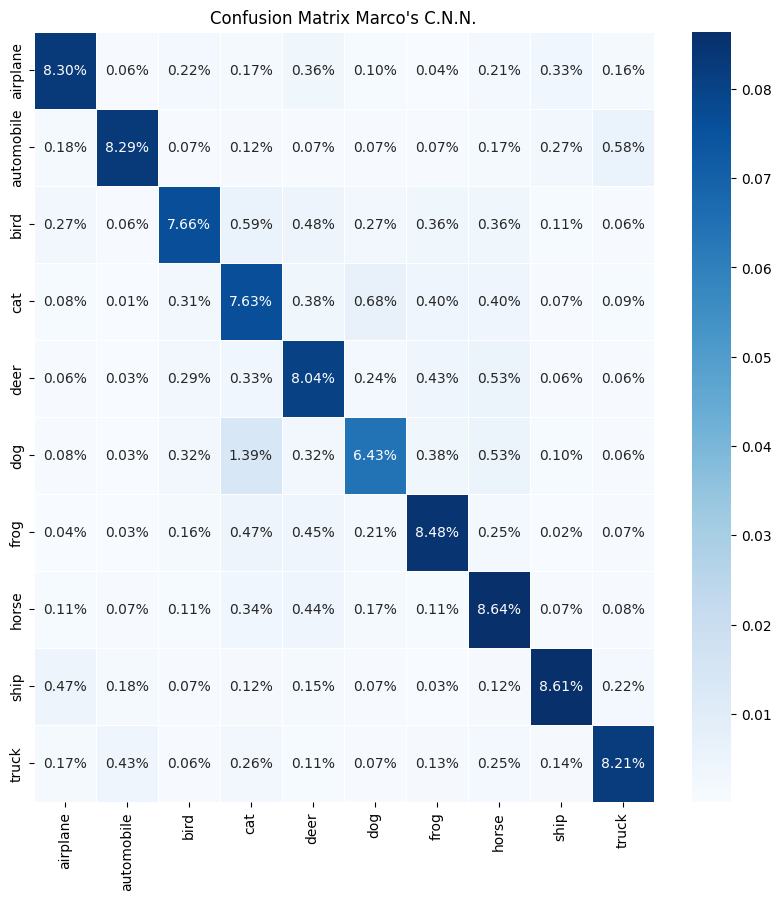

In [11]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,  xticklabels=names, yticklabels=names, fmt='.2%', cmap='Blues', linewidths=.5, ax=ax)
ax.set_title('Confusion Matrix Marco\'s C.N.N.')
plt.show()

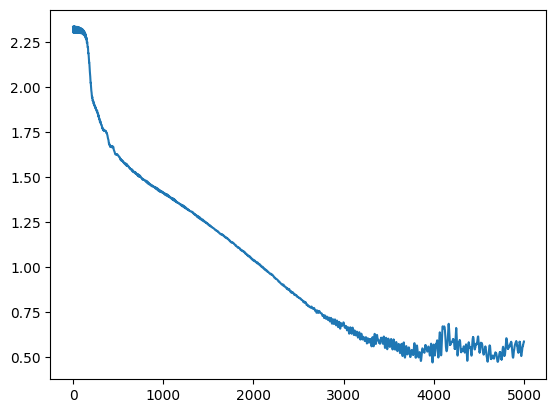

In [12]:
plt.plot(net.losses)
plt.show()

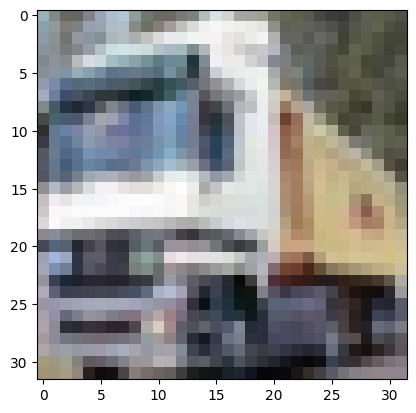

In [13]:
plot_tensor(x_train_tensors[1])